In [0]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import cycle
from scipy import interp

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict, cross_validate, KFold
from sklearn.metrics import confusion_matrix,roc_auc_score,auc,precision_recall_fscore_support, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

# Data exploration


In [0]:
df = pd.read_csv('cmc.data', header=None, names=['Wife_age','Wife_edu','Husband_edu','num_children','Wife_religion','Wife_work','Husband_occupation','sol_index','media_exp','target'])

In [0]:
df.head()

,Wife_age,Wife_edu,Husband_edu,num_children,Wife_religion,Wife_work,Husband_occupation,sol_index,media_exp,target
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
Wife_age              1473 non-null int64
Wife_edu              1473 non-null int64
Husband_edu           1473 non-null int64
num_children          1473 non-null int64
Wife_religion         1473 non-null int64
Wife_work             1473 non-null int64
Husband_occupation    1473 non-null int64
sol_index             1473 non-null int64
media_exp             1473 non-null int64
target                1473 non-null int64
dtypes: int64(10)
memory usage: 115.2 KB


In [0]:
df.describe()

,Wife_age,Wife_edu,Husband_edu,num_children,Wife_religion,Wife_work,Husband_occupation,sol_index,media_exp,target
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,32.538357,2.958588,3.429735,3.261371,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891
std,8.227245,1.014994,0.816349,2.358549,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


## Analyse correlation structure in the data 

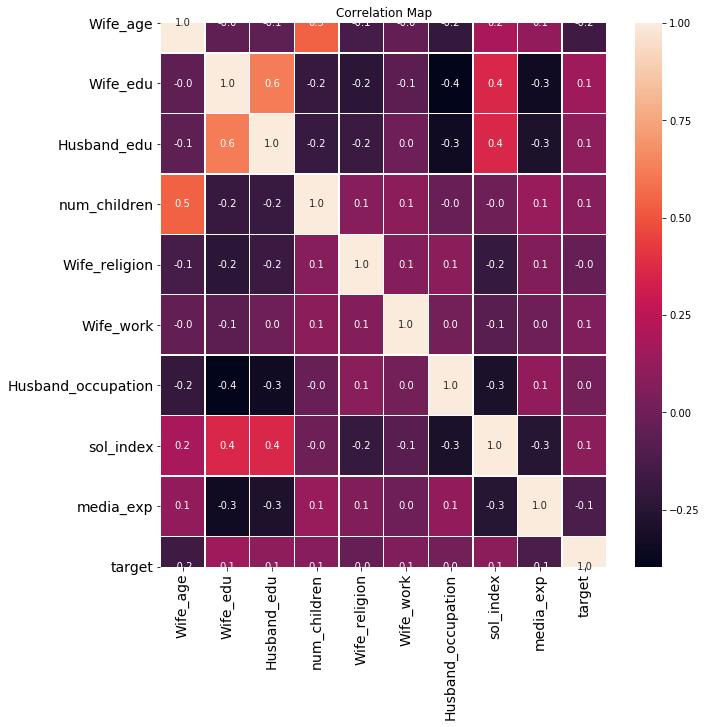

In [0]:
f,ax=plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title('Correlation Map')
plt.savefig('correlation1_graph.png')
plt.show()

In [0]:
df.corr()

,Wife_age,Wife_edu,Husband_edu,num_children,Wife_religion,Wife_work,Husband_occupation,sol_index,media_exp,target
Wife_age,1.000000,-0.048011,-0.052879,0.540126,-0.139543,-0.039880,-0.202532,0.184485,0.113306,-0.162953
Wife_edu,-0.048011,1.000000,0.618369,-0.193839,-0.232973,-0.062200,-0.395921,0.361450,-0.336080,0.149777
Husband_edu,-0.052879,0.618369,1.000000,-0.187513,-0.178447,0.001099,-0.337003,0.357490,-0.288691,0.103226
num_children,0.540126,-0.193839,-0.187513,1.000000,0.073917,0.097316,-0.023000,-0.006046,0.133658,0.082772
Wife_religion,-0.139543,-0.232973,-0.178447,0.073917,1.000000,0.069837,0.084417,-0.196308,0.060243,-0.025271
Wife_work,-0.039880,-0.062200,0.001099,0.097316,0.069837,1.000000,0.014232,-0.076505,0.001828,0.054438
Husband_occupation,-0.202532,-0.395921,-0.337003,-0.023000,0.084417,0.014232,1.000000,-0.293831,0.113925,0.018161
sol_index,0.184485,0.361450,0.357490,-0.006046,-0.196308,-0.076505,-0.293831,1.000000,-0.251359,0.091149
media_exp,0.113306,-0.336080,-0.288691,0.133658,0.060243,0.001828,0.113925,-0.251359,1.000000,-0.119206
target,-0.162953,0.149777,0.103226,0.082772,-0.025271,0.054438,0.018161,0.091149,-0.119206,1.000000


# Preprocessing
https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
<br>
Encode categorical variables with ordinal scale: Wife_edu, sol_index, Husband_edu <br>
..with nominal scale: Husband_occupation, target 

In [0]:
a = pd.get_dummies(df.Wife_edu, prefix='Wife_edu')
b = pd.get_dummies(df.sol_index, prefix='sol_index')
c = pd.get_dummies(df.Husband_edu, prefix='Husband_edu')
d = pd.get_dummies(df.Husband_occupation, prefix='Husband_occupation')
frames = [df, a, b, c, d]
new_df = pd.concat(frames, axis = 1)
new_df = new_df.drop(columns = ['Wife_edu','sol_index','Husband_edu','Husband_occupation'])
new_df.head()

,Wife_age,num_children,Wife_religion,Wife_work,media_exp,target,Wife_edu_1,Wife_edu_2,Wife_edu_3,Wife_edu_4,sol_index_1,sol_index_2,sol_index_3,sol_index_4,Husband_edu_1,Husband_edu_2,Husband_edu_3,Husband_edu_4,Husband_occupation_1,Husband_occupation_2,Husband_occupation_3,Husband_occupation_4
0,24,3,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,45,10,1,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
2,43,7,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,42,9,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0
4,36,8,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0


# Supervised classification: Naïve Bayes

## Training set (70%) and test set (30%)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_df.loc[:,new_df.columns!='target'], new_df.target, test_size=0.3)
clf_train_test = GaussianNB()
start = time.clock()
clf_train_test.fit(X_train, y_train)
end = time.clock()
print('Training time: ', end-start)

Training time:  0.00369800000001419


In [0]:
# Accuracy
clf_train_test.score(X_test,y_test)

0.4343891402714932

In [0]:
# Confusion matrix
start = time.clock()
X_predicted = clf_train_test.predict(X_test)
end = time.clock()
print('Prediction time: ', end-start)
conf = confusion_matrix(y_test,X_predicted, labels=[1,2,3])
pd.DataFrame(conf, index=['pred_1','pred_2','pred_3'], columns=['actual_1','actual_2','actual_3'])

Prediction time:  0.002726000000023987


,actual_1,actual_2,actual_3
pred_1,68,66,55
pred_2,9,66,36
pred_3,24,60,58


In [0]:
# Sensitivity and specificity
for i in range(3):
  print('cmc ',i+1)
  sens = np.round(conf[i,i]/float(np.sum(conf[:,i])),2)
  spec = np.round((np.sum(conf[:,i])-conf[i,i])/float(np.sum(conf)-np.sum(conf[i,:])-np.sum(conf[:,i])+conf[i,i]),4)
  print('sens: ', sens, 'spec: ', spec)

cmc  1
sens:  0.67 spec:  0.15
cmc  2
sens:  0.34 spec:  0.6146
cmc  3
sens:  0.39 spec:  0.4354


In [0]:
# Precision, recall, F1 score
precision_recall_fscore_support(y_test, X_predicted)

(array([0.67326733, 0.34375   , 0.38926174]),
 array([0.35978836, 0.59459459, 0.4084507 ]),
 array([0.46896552, 0.43564356, 0.39862543]),
 array([189, 111, 142]))

In [0]:
precision_recall_fscore_support(y_test, X_predicted, average='micro')

(0.4343891402714932, 0.4343891402714932, 0.4343891402714932, None)

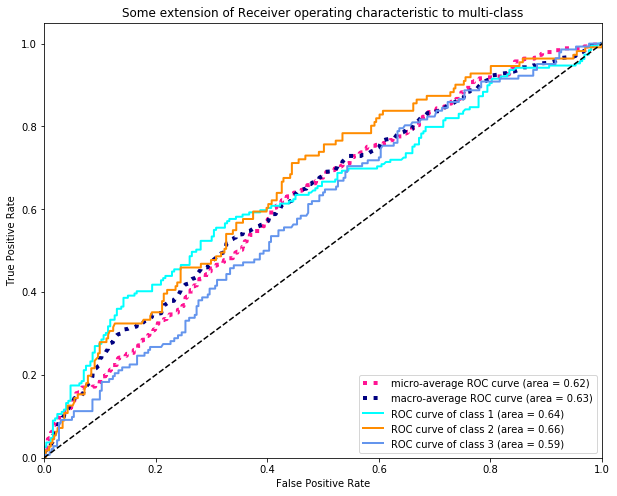

In [0]:
# ROC curve and auc_roc score
# ------
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# ------
from sklearn.metrics import roc_curve, auc
# Binarize the train and test target variables
y_train_b = label_binarize(y_train, classes=[1,2,3])
y_test_b = label_binarize(y_test, classes=[1,2,3])
n_classes = y_train_b.shape[1]

y_score = clf_train_test.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

__Robustness__<br>
https://machinelearningmastery.com/train-neural-networks-with-noise-to-reduce-overfitting/
- Standard deviation parameter controls amount of noise
- only add noise in training, NOT IN VALIDATION!
- in order to guarantee that the noise ahs the same effect on all attributes, rescale data first (standardization, normalizations)...after noise added again rescaling??

In [0]:
# Robustness 
for s in [0, 0.1,1,2]:
  print('sdev: ', s)
  mu, sigma = 0, s
  # creating a noise with the same dimension as the dataset
  noise = np.random.normal(mu, sigma, np.array(X_train.shape)) 
  tmp = X_train+noise
  clf = GaussianNB()
  start = time.clock()
  clf.fit(tmp, y_train)
  end = time.clock()
  print('Training time: ', end-start)
  print('Accuracy: ', clf.score(X_test,y_test))

sdev:  0
Training time:  0.0031219999999905212
Accuracy:  0.4343891402714932
sdev:  0.1
Training time:  0.0022120000000143136
Accuracy:  0.43891402714932126
sdev:  1
Training time:  0.0022069999999985157
Accuracy:  0.4683257918552036
sdev:  2
Training time:  0.0016479999999887696
Accuracy:  0.4796380090497738


## 5-fold cross validation

In [0]:
X = new_df.loc[:,new_df.columns!='target']
Y = new_df.target
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}
results = cross_validate(GaussianNB(),X,Y,cv=5,scoring=scoring)
for key in results:
 print(key, results[key].mean())

fit_time 0.0037314891815185547
score_time 0.006927871704101562
test_accuracy 0.4344927147478198
test_precision 0.4344927147478198
test_recall 0.4344927147478198
test_f1_score 0.4344927147478197


In [0]:
# Confusion matrix
start = time.clock()
cross_predicted = cross_val_predict(GaussianNB(), X, Y, cv=5)
conf = confusion_matrix(Y,cross_predicted)
end = time.clock()
print('Prediction time: ', end-start)
pd.DataFrame(conf, index=['pred_1','pred_2','pred_3'], columns=['actual_1','actual_2','actual_3'])

Prediction time:  0.03527100000002292


,actual_1,actual_2,actual_3
pred_1,201,210,218
pred_2,36,228,69
pred_3,90,210,211


In [0]:
# Sensitivity and specificity
for i in range(3):
  print('cmc ',i+1)
  sens = np.round(conf[i,i]/float(np.sum(conf[:,i])),2)
  spec = np.round((np.sum(conf[:,i])-conf[i,i])/float(np.sum(conf)-np.sum(conf[i,:])-np.sum(conf[:,i])+conf[i,i]),4)
  print('sens: ', sens, 'spec: ', spec)

cmc  1
sens:  0.61 spec:  0.1755
cmc  2
sens:  0.35 spec:  0.5833
cmc  3
sens:  0.42 spec:  0.4252


In [0]:
# Robustness 
for s in [0, 0.1,1,2]:
  print('sdev: ', s)
  mu, sigma = 0, s
  # creating a noise with the same dimension as the dataset
  noise = np.random.normal(mu, sigma, np.array(X.shape)) 
  tmp = X+noise
  results_kfold= cross_validate(GaussianNB(), tmp, Y, cv=5, scoring=make_scorer(accuracy_score))
  print('Mean Fit Time:',results_kfold.get('fit_time').mean())
  print('Mean Score Time:',results_kfold.get('score_time').mean())
  print('Mean Accuracy:',results_kfold.get('test_score').mean())
  # print(results_kfold)

sdev:  0
Mean Fit Time: 0.002998161315917969
Mean Score Time: 0.0015144824981689453
Mean Accuracy: 0.4344927147478198
sdev:  0.1
Mean Fit Time: 0.002835655212402344
Mean Score Time: 0.0013525009155273438
Mean Accuracy: 0.44060601776399777
sdev:  1
Mean Fit Time: 0.0034888744354248046
Mean Score Time: 0.0015269279479980468
Mean Accuracy: 0.4866502955793422
sdev:  2
Mean Fit Time: 0.0030185699462890623
Mean Score Time: 0.001556730270385742
Mean Accuracy: 0.45077569674157536


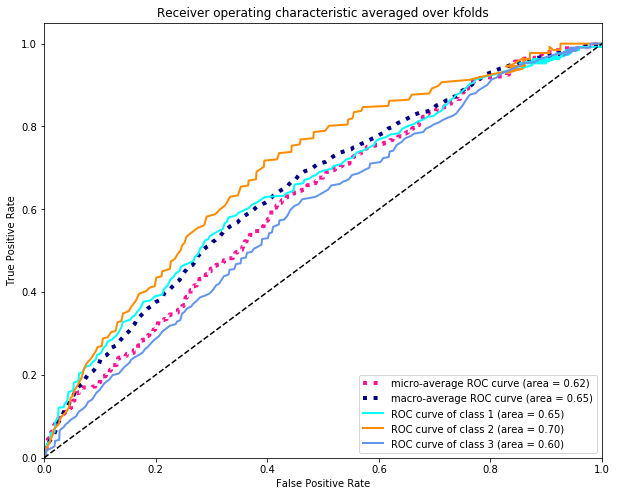

In [0]:
# roc_auc
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# ------
n_samples, n_features = X.shape

# #############################################################################
# Classification and ROC analysis
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = GaussianNB()

tprs = dict()
aucs = dict()
fprs = dict()
for i in range(n_classes):
  tprs[i+1] = []
  aucs[i+1] = []
  fprs[i+1] = []
tprs["micro"] = []
aucs["micro"] = []
fprs["micro"] = []
tprs["macro"] = []
aucs["macro"] = []
fprs["macro"] = []
r = 0
for train, test in cv.split(X, Y):
  y_train = label_binarize(Y.iloc[train], classes=[1, 2, 3])
  y_test = label_binarize(Y.iloc[test], classes=[1, 2, 3])
  n_classes = y_train.shape[1]
  # Compute ROC curve and ROC area for each class
  clf = classifier.fit(X.iloc[train], Y.iloc[train])
  probas_ = clf.predict_proba(X.iloc[test])
  for i in range(n_classes):
    # print(probas_)
    fpr, tpr, _ = roc_curve(y_test[:, i], probas_[:, i])
    roc_auc = auc(fpr, tpr)
    tprs[i+1].append(tpr)
    aucs[i+1].append(roc_auc)
    fprs[i+1].append(fpr)
    

  # Compute micro-average ROC curve and ROC area
  fpr_micro, tpr_micro, _ = roc_curve(y_test_b.ravel(), y_score.ravel())
  roc_auc_micro = auc(fpr_micro, tpr_micro)
  tprs["micro"].append(tpr_micro)
  aucs["micro"].append(roc_auc_micro)
  fprs["micro"].append(fpr_micro)
  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fprs[i+1][r] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fprs[i+1][r], tprs[i+1][r])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr_macro = all_fpr
  tpr_macro = mean_tpr
  roc_auc_macro = auc(fpr_macro, tpr_macro)
  tprs["macro"].append(tpr_macro)
  aucs["macro"].append(roc_auc_macro)
  fprs["macro"] .append(fpr_macro)
  r += 1

from itertools import zip_longest

for i in range(n_classes):
  tprs[i+1] = np.nanmean(np.array(list(zip_longest(*tprs[i+1])),dtype=float),axis=1)
  aucs[i+1] = np.mean(aucs[i+1])
  fprs[i+1] = np.nanmean(np.array(list(zip_longest(*fprs[i+1])),dtype=float),axis=1)
tprs["micro"] = np.nanmean(np.array(list(zip_longest(*tprs["micro"])),dtype=float),axis=1)
aucs["micro"] = np.mean(aucs["micro"])
fprs["micro"] = np.nanmean(np.array(list(zip_longest(*fprs["micro"])),dtype=float),axis=1)
tprs["macro"] = np.nanmean(np.array(list(zip_longest(*tprs["macro"])),dtype=float),axis=1)
aucs["macro"] = np.mean(aucs["macro"])
fprs["macro"] = np.nanmean(np.array(list(zip_longest(*fprs["macro"])),dtype=float),axis=1)
# Plot all ROC curves
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fprs["micro"], tprs["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(aucs["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fprs["macro"], tprs["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(aucs["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fprs[i+1], tprs[i+1], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, aucs[i+1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic averaged over kfolds')
plt.legend(loc="lower right")
plt.show()

## Leave-one-out validation
https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo

In [0]:
from sklearn.model_selection import KFold
X = new_df.loc[:,new_df.columns!='target']
Y = new_df.target
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}
kfold = KFold(n_splits=X.shape[0], random_state=100)
results_kfold = cross_validate(GaussianNB(), X, Y, cv=kfold, scoring=scoring)
print('Mean Fit Time:',results_kfold.get('fit_time').mean())
print('Mean Score Time:',results_kfold.get('score_time').mean())
print('Mean Accuracy:',results_kfold.get('test_accuracy').mean())
print('Mean Precision:',results_kfold.get('test_precision').mean())
print('Mean Recall:',results_kfold.get('test_recall').mean())
print('Mean F1 Score:',results_kfold.get('test_f1_score').mean())
# print(results_kfold)

Mean Fit Time: 0.0034684241424995624
Mean Score Time: 0.006648365527047483
Mean Accuracy: 0.43380855397148677
Mean Precision: 0.43380855397148677
Mean Recall: 0.43380855397148677
Mean F1 Score: 0.43380855397148677


In [0]:
# Confusion matrix
start = time.clock()
cross_predicted = cross_val_predict(GaussianNB(), X, Y, cv=kfold)
conf = confusion_matrix(Y,cross_predicted)
end = time.clock()
print('Prediction time: ', end-start)
pd.DataFrame(conf, index=['pred_1','pred_2','pred_3'], columns=['actual_1','actual_2','actual_3'])

Prediction time:  6.620859000000024


,actual_1,actual_2,actual_3
pred_1,204,211,214
pred_2,33,226,74
pred_3,89,213,209


In [0]:
# Sensitivity and specificity
for i in range(3):
  print('cmc ',i+1)
  sens = np.round(conf[i,i]/float(np.sum(conf[:,i])),2)
  spec = np.round((np.sum(conf[:,i])-conf[i,i])/float(np.sum(conf)-np.sum(conf[i,:])-np.sum(conf[:,i])+conf[i,i]),4)
  print('sens: ', sens, 'spec: ', spec)

cmc  1
sens:  0.63 spec:  0.169
cmc  2
sens:  0.35 spec:  0.5922
cmc  3
sens:  0.42 spec:  0.4273


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:113: RuntimeWa

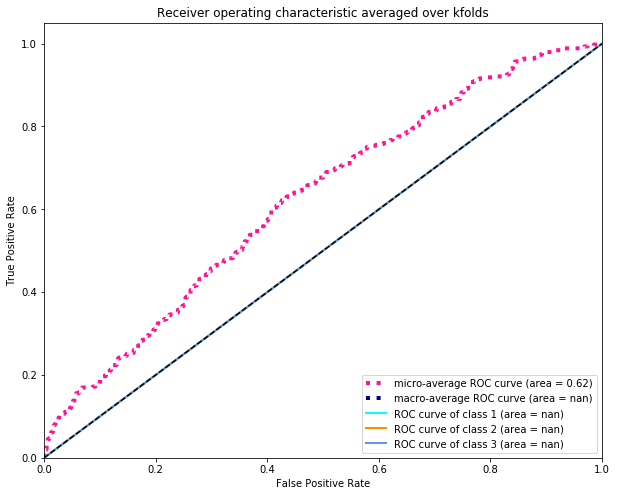

In [0]:
# roc_auc
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# ------
n_samples, n_features = X.shape

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = kfold
classifier = GaussianNB()

tprs = dict()
aucs = dict()
fprs = dict()
for i in range(n_classes):
  tprs[i+1] = []
  aucs[i+1] = []
  fprs[i+1] = []
tprs["micro"] = []
aucs["micro"] = []
fprs["micro"] = []
tprs["macro"] = []
aucs["macro"] = []
fprs["macro"] = []
r = 0
for train, test in cv.split(X, Y):
  y_train = label_binarize(Y.iloc[train], classes=[1, 2, 3])
  y_test = label_binarize(Y.iloc[test], classes=[1, 2, 3])
  n_classes = y_train.shape[1]
  # Compute ROC curve and ROC area for each class
  clf = classifier.fit(X.iloc[train], Y.iloc[train])
  probas_ = clf.predict_proba(X.iloc[test])
  for i in range(n_classes):
    # print(probas_)
    fpr, tpr, _ = roc_curve(y_test[:, i], probas_[:, i])
    roc_auc = auc(fpr, tpr)
    tprs[i+1].append(tpr)
    aucs[i+1].append(roc_auc)
    fprs[i+1].append(fpr)
    

  # Compute micro-average ROC curve and ROC area
  fpr_micro, tpr_micro, _ = roc_curve(y_test_b.ravel(), y_score.ravel())
  roc_auc_micro = auc(fpr_micro, tpr_micro)
  tprs["micro"].append(tpr_micro)
  aucs["micro"].append(roc_auc_micro)
  fprs["micro"].append(fpr_micro)
  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fprs[i+1][r] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fprs[i+1][r], tprs[i+1][r])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr_macro = all_fpr
  tpr_macro = mean_tpr
  roc_auc_macro = auc(fpr_macro, tpr_macro)
  tprs["macro"].append(tpr_macro)
  aucs["macro"].append(roc_auc_macro)
  fprs["macro"] .append(fpr_macro)
  r += 1

from itertools import zip_longest

for i in range(n_classes):
  tprs[i+1] = np.nanmean(np.array(list(zip_longest(*tprs[i+1])),dtype=float),axis=1)
  aucs[i+1] = np.mean(aucs[i+1])
  fprs[i+1] = np.nanmean(np.array(list(zip_longest(*fprs[i+1])),dtype=float),axis=1)
tprs["micro"] = np.nanmean(np.array(list(zip_longest(*tprs["micro"])),dtype=float),axis=1)
aucs["micro"] = np.mean(aucs["micro"])
fprs["micro"] = np.nanmean(np.array(list(zip_longest(*fprs["micro"])),dtype=float),axis=1)
tprs["macro"] = np.nanmean(np.array(list(zip_longest(*tprs["macro"])),dtype=float),axis=1)
aucs["macro"] = np.mean(aucs["macro"])
fprs["macro"] = np.nanmean(np.array(list(zip_longest(*fprs["macro"])),dtype=float),axis=1)
# Plot all ROC curves
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fprs["micro"], tprs["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(aucs["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fprs["macro"], tprs["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(aucs["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fprs[i+1], tprs[i+1], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, aucs[i+1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic averaged over kfolds')
plt.legend(loc="lower right")
plt.show()

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

# #############################################################################
# Data IO and generation

# Import some data to play with
X = new_df.loc[:,new_df.columns!='target'].values
y = new_df.target.values
n_samples, n_features = X.shape

# #############################################################################
# Classification and ROC analysi

# Run classifier with cross-validation and plot ROC curves
cv = kfold
classifier = GaussianNB()
n_classes = 3
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X, y):
    # Binarize the train and test target variables
    y_train_b = label_binarize(y[train], classes=[1,2,3])
    y_test_b = label_binarize(y[test], classes=[1,2,3])
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test_b.ravel(), probas_.ravel())
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

__Robustness__<br>
https://machinelearningmastery.com/train-neural-networks-with-noise-to-reduce-overfitting/
- Standard deviation parameter controls amount of noise
- only add noise in training, NOT IN VALIDATION!
- in order to guarantee that the noise ahs the same effect on all attributes, rescale data first (standardization, normalizations)...after noise added again rescaling??

In [0]:
# Robustness 
for s in [0, 0.1,1,2]:
  print('sdev: ', s)
  mu, sigma = 0, s
  # creating a noise with the same dimension as the dataset
  noise = np.random.normal(mu, sigma, np.array(X.shape)) 
  tmp = X+noise
  results_kfold= cross_validate(GaussianNB(), tmp, Y, cv=kfold, scoring=make_scorer(accuracy_score))
  print('Mean Fit Time:',results_kfold.get('fit_time').mean())
  print('Mean Score Time:',results_kfold.get('score_time').mean())
  print('Mean Accuracy:',results_kfold.get('test_score').mean())
  # print(results_kfold)

sdev:  0
Mean Fit Time: 0.0026977547802895974
Mean Score Time: 0.0011335518274352573
Mean Accuracy: 0.43380855397148677
sdev:  0.1
Mean Fit Time: 0.002651573279562728
Mean Score Time: 0.0011173160563337503
Mean Accuracy: 0.4378818737270876
sdev:  1
Mean Fit Time: 0.002637405583264467
Mean Score Time: 0.001108761312843421
Mean Accuracy: 0.46028513238289204
sdev:  2
Mean Fit Time: 0.002701495346048618
Mean Score Time: 0.001193690607520244
Mean Accuracy: 0.439918533604888


# Supervised classification: k-nearest Neighbors

## Finding k

In [0]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(new_df.loc[:,new_df.columns!='target'], new_df.target, test_size=0.3)
best_score = 0
best_k = 0
for k in range(1,50):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train, y_train) 
  score = neigh.score(X_test,y_test)
  if score > best_score:
    best_score = score
    best_k = k
print("Best k:",best_k)

Best k: 30


## Training set (70%) and test set (30%)

In [0]:
#Accuracy
neigh = KNeighborsClassifier(n_neighbors=best_k)
start = time.clock()
neigh.fit(X_train, y_train) 
end = time.clock()
print('Training time: ', end-start)
score = neigh.score(X_test,y_test)
print("Score with best k:",score)

Training time:  0.005570999999974902
Score with best k: 0.5497737556561086


In [0]:
# Confusion matrix
start = time.clock()
X_predicted = neigh.predict(X_test)
conf = confusion_matrix(y_test,X_predicted, labels=[1,2,3])
end = time.clock()
print('Prediction time: ', end-start)
pd.DataFrame(conf, index=['pred_1','pred_2','pred_3'], columns=['actual_1','actual_2','actual_3'])

Prediction time:  0.02556699999996681


,actual_1,actual_2,actual_3
pred_1,124,11,40
pred_2,33,32,35
pred_3,51,29,87


In [0]:
# Sensitivity and specificity
for i in range(3):
  print('cmc ',i+1)
  sens = np.round(conf[i,i]/float(np.sum(conf[:,i])),2)
  spec = np.round((np.sum(conf[:,i])-conf[i,i])/float(np.sum(conf)-np.sum(conf[i,:])-np.sum(conf[:,i])+conf[i,i]),4)
  print('sens: ', sens, 'spec: ', spec)

cmc  1
sens:  0.6 spec:  0.459
cmc  2
sens:  0.44 spec:  0.1325
cmc  3
sens:  0.54 spec:  0.375


In [0]:
# Precision, recall, F1 score
precision_recall_fscore_support(y_test, X_predicted)

(array([0.59388646, 0.50649351, 0.52941176]),
 array([0.71957672, 0.35454545, 0.5034965 ]),
 array([0.6507177 , 0.4171123 , 0.51612903]),
 array([189, 110, 143]))

In [0]:
precision_recall_fscore_support(y_test, X_predicted, average='micro')

(0.5588235294117647, 0.5588235294117647, 0.5588235294117647, None)

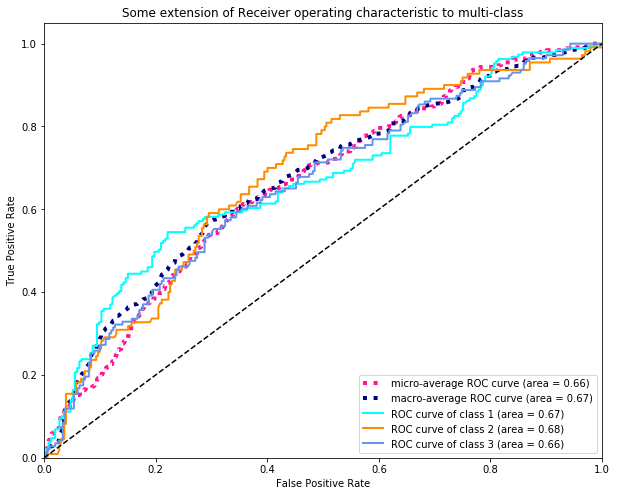

In [0]:
# ROC curve and auc_roc score
# ------
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# ------

# Binarize the train and test target variables
y_train_b = label_binarize(y_train, classes=[1,2,3])
n_classes = y_train_b.shape[1]
y_test_b = label_binarize(y_test, classes=[1,2,3])

# Add noisy features to make the problem harder
#random_state = np.random.RandomState(0)
#n_samples, n_features = X.shape
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

y_score = clf_train_test.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [0]:
# Robustness 
for s in [0, 0.1,1,2]:
  print('sdev: ', s)
  mu, sigma = 0, s
  # creating a noise with the same dimension as the dataset
  noise = np.random.normal(mu, sigma, np.array(X_train.shape)) 
  tmp = X_train+noise
  clf = KNeighborsClassifier(n_neighbors=best_k)
  start = time.clock()
  clf.fit(tmp, y_train)
  end = time.clock()
  print('Training time: ', end-start)
  print('Accuracy: ', clf.score(X_test,y_test))

sdev:  0
Training time:  0.0018650000000093314
Accuracy:  0.5588235294117647
sdev:  0.1
Training time:  0.0019419999999854554
Accuracy:  0.5361990950226244
sdev:  1
Training time:  0.0021100000000160435
Accuracy:  0.4502262443438914
sdev:  2
Training time:  0.0020380000000272958
Accuracy:  0.43891402714932126


## 5-fold cross validation

In [0]:
from sklearn.model_selection import KFold
X = new_df.loc[:,new_df.columns!='target']
Y = new_df.target
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}
results_kfold = cross_validate(KNeighborsClassifier(n_neighbors=best_k), X, Y, cv=5, scoring=scoring)
print('Mean Fit Time:',results_kfold.get('fit_time').mean())
print('Mean Score Time:',results_kfold.get('score_time').mean())
print('Mean Accuracy:',results_kfold.get('test_accuracy').mean())
print('Mean Precision:',results_kfold.get('test_precision').mean())
print('Mean Recall:',results_kfold.get('test_recall').mean())
print('Mean F1 Score:',results_kfold.get('test_f1_score').mean())
# print(results_kfold)

Mean Fit Time: 0.0036449432373046875
Mean Score Time: 0.06552238464355468
Mean Accuracy: 0.5275570292467796
Mean Precision: 0.5275570292467796
Mean Recall: 0.5275570292467796
Mean F1 Score: 0.5275570292467796


In [0]:
# Confusion matrix
start = time.clock()
cross_predicted = cross_val_predict(KNeighborsClassifier(n_neighbors=best_k), X, Y, cv=5)
conf = confusion_matrix(Y,cross_predicted)
end = time.clock()
print('Prediction time: ', end-start)
pd.DataFrame(conf, index=['pred_1','pred_2','pred_3'], columns=['actual_1','actual_2','actual_3'])

Prediction time:  0.09517600000003767


,actual_1,actual_2,actual_3
pred_1,391,81,157
pred_2,105,124,104
pred_3,138,111,262


In [0]:
# Sensitivity and specificity
for i in range(3):
  print('cmc ',i+1)
  sens = np.round(conf[i,i]/float(np.sum(conf[:,i])),2)
  spec = np.round((np.sum(conf[:,i])-conf[i,i])/float(np.sum(conf)-np.sum(conf[i,:])-np.sum(conf[:,i])+conf[i,i]),4)
  print('sens: ', sens, 'spec: ', spec)

cmc  1
sens:  0.62 spec:  0.4043
cmc  2
sens:  0.39 spec:  0.2025
cmc  3
sens:  0.5 spec:  0.3723


In [0]:
# Robustness 
for s in [0, 0.1,1,2]:
  print('sdev: ', s)
  mu, sigma = 0, s
  # creating a noise with the same dimension as the dataset
  noise = np.random.normal(mu, sigma, np.array(X.shape)) 
  tmp = X+noise
  results_kfold= cross_validate(KNeighborsClassifier(n_neighbors=best_k), tmp, Y, cv=5, scoring=make_scorer(accuracy_score))
  print('Mean Fit Time:',results_kfold.get('fit_time').mean())
  print('Mean Score Time:',results_kfold.get('score_time').mean())
  print('Mean Accuracy:',results_kfold.get('test_score').mean())
  # print(results_kfold)

sdev:  0
Mean Fit Time: 0.003175830841064453
Mean Score Time: 0.01486811637878418
Mean Accuracy: 0.5275570292467796
sdev:  0.1
Mean Fit Time: 0.0029574871063232423
Mean Score Time: 0.013581991195678711
Mean Accuracy: 0.5322888614717735
sdev:  1
Mean Fit Time: 0.0028809070587158202
Mean Score Time: 0.017316532135009766
Mean Accuracy: 0.4656517326380725
sdev:  2
Mean Fit Time: 0.0030605316162109373
Mean Score Time: 0.02059025764465332
Mean Accuracy: 0.4222820935184065


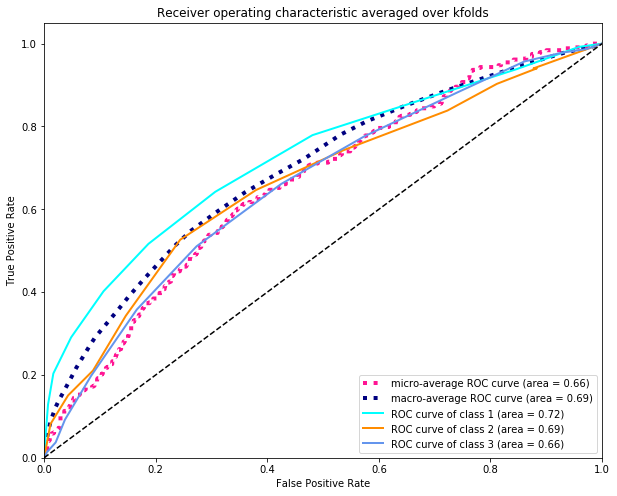

In [0]:
# roc_auc
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# ------
n_samples, n_features = X.shape

# #############################################################################
# Classification and ROC analysis
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = KNeighborsClassifier(n_neighbors=best_k)

tprs = dict()
aucs = dict()
fprs = dict()
for i in range(n_classes):
  tprs[i+1] = []
  aucs[i+1] = []
  fprs[i+1] = []
tprs["micro"] = []
aucs["micro"] = []
fprs["micro"] = []
tprs["macro"] = []
aucs["macro"] = []
fprs["macro"] = []
r = 0
for train, test in cv.split(X, Y):
  y_train = label_binarize(Y.iloc[train], classes=[1, 2, 3])
  y_test = label_binarize(Y.iloc[test], classes=[1, 2, 3])
  n_classes = y_train.shape[1]
  # Compute ROC curve and ROC area for each class
  clf = classifier.fit(X.iloc[train], Y.iloc[train])
  probas_ = clf.predict_proba(X.iloc[test])
  for i in range(n_classes):
    # print(probas_)
    fpr, tpr, _ = roc_curve(y_test[:, i], probas_[:, i])
    roc_auc = auc(fpr, tpr)
    tprs[i+1].append(tpr)
    aucs[i+1].append(roc_auc)
    fprs[i+1].append(fpr)
    

  # Compute micro-average ROC curve and ROC area
  fpr_micro, tpr_micro, _ = roc_curve(y_test_b.ravel(), y_score.ravel())
  roc_auc_micro = auc(fpr_micro, tpr_micro)
  tprs["micro"].append(tpr_micro)
  aucs["micro"].append(roc_auc_micro)
  fprs["micro"].append(fpr_micro)
  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fprs[i+1][r] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fprs[i+1][r], tprs[i+1][r])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr_macro = all_fpr
  tpr_macro = mean_tpr
  roc_auc_macro = auc(fpr_macro, tpr_macro)
  tprs["macro"].append(tpr_macro)
  aucs["macro"].append(roc_auc_macro)
  fprs["macro"] .append(fpr_macro)
  r += 1

from itertools import zip_longest

for i in range(n_classes):
  tprs[i+1] = np.nanmean(np.array(list(zip_longest(*tprs[i+1])),dtype=float),axis=1)
  aucs[i+1] = np.mean(aucs[i+1])
  fprs[i+1] = np.nanmean(np.array(list(zip_longest(*fprs[i+1])),dtype=float),axis=1)
tprs["micro"] = np.nanmean(np.array(list(zip_longest(*tprs["micro"])),dtype=float),axis=1)
aucs["micro"] = np.mean(aucs["micro"])
fprs["micro"] = np.nanmean(np.array(list(zip_longest(*fprs["micro"])),dtype=float),axis=1)
tprs["macro"] = np.nanmean(np.array(list(zip_longest(*tprs["macro"])),dtype=float),axis=1)
aucs["macro"] = np.mean(aucs["macro"])
fprs["macro"] = np.nanmean(np.array(list(zip_longest(*fprs["macro"])),dtype=float),axis=1)
# Plot all ROC curves
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fprs["micro"], tprs["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(aucs["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fprs["macro"], tprs["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(aucs["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fprs[i+1], tprs[i+1], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, aucs[i+1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic averaged over kfolds')
plt.legend(loc="lower right")
plt.show()

## Leave-one-out validation

In [0]:
from sklearn.model_selection import KFold
X = new_df.loc[:,new_df.columns!='target']
Y = new_df.target
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}
kfold = KFold(n_splits=X.shape[0], random_state=100)
results_kfold = cross_validate(KNeighborsClassifier(n_neighbors=best_k), X, Y, cv=kfold, scoring=scoring)
print('Mean Fit Time:',results_kfold.get('fit_time').mean())
print('Mean Score Time:',results_kfold.get('score_time').mean())
print('Mean Accuracy:',results_kfold.get('test_accuracy').mean())
print('Mean Precision:',results_kfold.get('test_precision').mean())
print('Mean Recall:',results_kfold.get('test_recall').mean())
print('Mean F1 Score:',results_kfold.get('test_f1_score').mean())
# print(results_kfold)

Mean Fit Time: 0.0032330310352789004
Mean Score Time: 0.008466895227115008
Mean Accuracy: 0.5247793618465716
Mean Precision: 0.5247793618465716
Mean Recall: 0.5247793618465716
Mean F1 Score: 0.5247793618465716


In [0]:
# Confusion matrix
start = time.clock()
cross_predicted = cross_val_predict(KNeighborsClassifier(n_neighbors=best_k), X, Y, cv=kfold)
conf = confusion_matrix(Y,cross_predicted)
end = time.clock()
print('Prediction time: ', end-start)
pd.DataFrame(conf, index=['pred_1','pred_2','pred_3'], columns=['actual_1','actual_2','actual_3'])

Prediction time:  7.362376999999981


,actual_1,actual_2,actual_3
pred_1,390,80,159
pred_2,98,124,111
pred_3,151,101,259


In [0]:
# Sensitivity and specificity
for i in range(3):
  print('cmc ',i+1)
  sens = np.round(conf[i,i]/float(np.sum(conf[:,i])),2)
  spec = np.round((np.sum(conf[:,i])-conf[i,i])/float(np.sum(conf)-np.sum(conf[i,:])-np.sum(conf[:,i])+conf[i,i]),4)
  print('sens: ', sens, 'spec: ', spec)

cmc  1
sens:  0.61 spec:  0.4185
cmc  2
sens:  0.41 spec:  0.1887
cmc  3
sens:  0.49 spec:  0.3902


In [0]:
# Robustness 
for s in [0, 0.1,1,2]:
  print('sdev: ', s)
  mu, sigma = 0, s
  # creating a noise with the same dimension as the dataset
  noise = np.random.normal(mu, sigma, np.array(X.shape)) 
  tmp = X+noise
  results_kfold= cross_validate(KNeighborsClassifier(n_neighbors=best_k), tmp, Y, cv=kfold, scoring=make_scorer(accuracy_score))
  print('Mean Fit Time:',results_kfold.get('fit_time').mean())
  print('Mean Score Time:',results_kfold.get('score_time').mean())
  print('Mean Accuracy:',results_kfold.get('test_score').mean())
  # print(results_kfold)

sdev:  0
Mean Fit Time: 0.002934551530360204
Mean Score Time: 0.0017243462683631705
Mean Accuracy: 0.5247793618465716
sdev:  0.1
Mean Fit Time: 0.0028671243930461854
Mean Score Time: 0.001656682007343528
Mean Accuracy: 0.5234215885947047
sdev:  1
Mean Fit Time: 0.0029230873680244234
Mean Score Time: 0.0017331057637221781
Mean Accuracy: 0.47182620502376105
sdev:  2
Mean Fit Time: 0.0029859816388701876
Mean Score Time: 0.0018444632642218958
Mean Accuracy: 0.43380855397148677


In [0]:
# roc_auc
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# ------
n_samples, n_features = X.shape

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = kfold
classifier = KNeighborsClassifier(n_neighbors=best_k)

tprs = dict()
aucs = dict()
fprs = dict()
for i in range(n_classes):
  tprs[i+1] = []
  aucs[i+1] = []
  fprs[i+1] = []
tprs["micro"] = []
aucs["micro"] = []
fprs["micro"] = []
tprs["macro"] = []
aucs["macro"] = []
fprs["macro"] = []
r = 0
for train, test in cv.split(X, Y):
  y_train = label_binarize(Y.iloc[train], classes=[1, 2, 3])
  y_test = label_binarize(Y.iloc[test], classes=[1, 2, 3])
  n_classes = y_train.shape[1]
  # Compute ROC curve and ROC area for each class
  clf = classifier.fit(X.iloc[train], Y.iloc[train])
  probas_ = clf.predict_proba(X.iloc[test])
  for i in range(n_classes):
    # print(probas_)
    fpr, tpr, _ = roc_curve(y_test[:, i], probas_[:, i])
    roc_auc = auc(fpr, tpr)
    tprs[i+1].append(tpr)
    aucs[i+1].append(roc_auc)
    fprs[i+1].append(fpr)
    

  # Compute micro-average ROC curve and ROC area
  fpr_micro, tpr_micro, _ = roc_curve(y_test_b.ravel(), y_score.ravel())
  roc_auc_micro = auc(fpr_micro, tpr_micro)
  tprs["micro"].append(tpr_micro)
  aucs["micro"].append(roc_auc_micro)
  fprs["micro"].append(fpr_micro)
  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fprs[i+1][r] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fprs[i+1][r], tprs[i+1][r])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr_macro = all_fpr
  tpr_macro = mean_tpr
  roc_auc_macro = auc(fpr_macro, tpr_macro)
  tprs["macro"].append(tpr_macro)
  aucs["macro"].append(roc_auc_macro)
  fprs["macro"] .append(fpr_macro)
  r += 1

from itertools import zip_longest

for i in range(n_classes):
  tprs[i+1] = np.nanmean(np.array(list(zip_longest(*tprs[i+1])),dtype=float),axis=1)
  aucs[i+1] = np.mean(aucs[i+1])
  fprs[i+1] = np.nanmean(np.array(list(zip_longest(*fprs[i+1])),dtype=float),axis=1)
tprs["micro"] = np.nanmean(np.array(list(zip_longest(*tprs["micro"])),dtype=float),axis=1)
aucs["micro"] = np.mean(aucs["micro"])
fprs["micro"] = np.nanmean(np.array(list(zip_longest(*fprs["micro"])),dtype=float),axis=1)
tprs["macro"] = np.nanmean(np.array(list(zip_longest(*tprs["macro"])),dtype=float),axis=1)
aucs["macro"] = np.mean(aucs["macro"])
fprs["macro"] = np.nanmean(np.array(list(zip_longest(*fprs["macro"])),dtype=float),axis=1)
# Plot all ROC curves
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fprs["micro"], tprs["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(aucs["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fprs["macro"], tprs["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(aucs["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fprs[i+1], tprs[i+1], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, aucs[i+1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic averaged over kfolds')
plt.legend(loc="lower right")
plt.show()

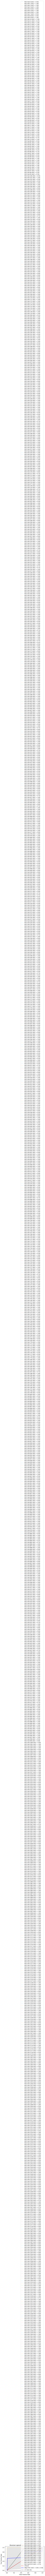

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

# #############################################################################
# Data IO and generation

# Import some data to play with
X = new_df.loc[:,new_df.columns!='target'].values
y = new_df.target.values
n_samples, n_features = X.shape

# #############################################################################
# Classification and ROC analysi

# Run classifier with cross-validation and plot ROC curves
cv = kfold
classifier = KNeighborsClassifier(n_neighbors=best_k)
n_classes = 3
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X, y):
    # Binarize the train and test target variables
    y_train_b = label_binarize(y[train], classes=[1,2,3])
    y_test_b = label_binarize(y[test], classes=[1,2,3])
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test_b.ravel(), probas_.ravel())
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



